In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

## Feature Building

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")

    X_quant_features = toxic_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)

     # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)   

## Create training and test sets

In [4]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='toxiccomments_train.csv', my_random_seed=42)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Training Data

## Model: SVM Linear

In [5]:
from sklearn import linear_model
svm = linear_model.SGDClassifier(loss='hinge', penalty='elasticnet', alpha=0.001, l1_ratio=0.5, fit_intercept=True, max_iter=1000, tol=0.001, shuffle=True, verbose=0, epsilon=0.1, n_jobs=None, random_state=None, learning_rate='optimal', eta0=0.0, power_t=0.5, early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, class_weight=None, warm_start=False, average=False)
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 12981, 'Neg': 114675, 'TP': 11273, 'TN': 113918, 'FP': 757, 'FN': 1708, 'Accuracy': 0.9806902926615279, 'Precision': 0.9370739817123857, 'Recall': 0.8684230798859872, 'desc': 'svm_train'}


In [6]:
from sklearn import linear_model

# alphas = [0, 0.5, 0.7, 5, 10, 50, 5000]

# for alpha in alphas:
rdg = linear_model.RidgeClassifier(alpha=20, fit_intercept=True, normalize=True, copy_X=True, max_iter=None, tol=0.001, class_weight='balanced', solver='sag', random_state=None)
rdg.fit(X_train, y_train)
rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 12981, 'Neg': 114675, 'TP': 12615, 'TN': 105167, 'FP': 9508, 'FN': 366, 'Accuracy': 0.9226515009086921, 'Precision': 0.570221036929892, 'Recall': 0.9718049456898544, 'desc': 'rdg_train'}


In [7]:
from sklearn import linear_model
rdg1 = linear_model.RidgeClassifier(normalize=True, alpha=3, tol=0.0001, solver='sag', random_state=0)
rdg1.fit(X_train, y_train)

rdg1_performance_train = BinaryClassificationPerformance(rdg1.predict(X_train), y_train, 'rdg1_train')
rdg1_performance_train.compute_measures()
print(rdg1_performance_train.performance_measures)

{'Pos': 12981, 'Neg': 114675, 'TP': 12896, 'TN': 101968, 'FP': 12707, 'FN': 85, 'Accuracy': 0.8997931942094378, 'Precision': 0.5036909737140179, 'Recall': 0.993451968261305, 'desc': 'rdg1_train'}


In [8]:
from sklearn.ensemble import VotingClassifier
#create a dictionary of our models
estimators=[('svm', svm), ('rdg', rdg), ('rdg1', rdg1)]
#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='hard')
ensemble.fit(X_train, y_train)
ensemble_performance_train = BinaryClassificationPerformance(ensemble.predict(X_train), y_train, 'ensemble_train')
ensemble_performance_train.compute_measures()
print(ensemble_performance_train.performance_measures)

{'Pos': 12981, 'Neg': 114675, 'TP': 12693, 'TN': 105844, 'FP': 8831, 'FN': 288, 'Accuracy': 0.9285658331766623, 'Precision': 0.5897138078424085, 'Recall': 0.977813727755951, 'desc': 'ensemble_train'}


### Looking at some false positives

In [9]:
ensemble_predictions = ensemble.predict(X_train)

# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ensemble_predictions)):
    if (ensemble_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')

Examples of false positives:
69
"

 1972 Olympics? 

Please see this discussion. Thanks. '''''' Dick Laurent is dead "
* * * * * * * * * 
279
Yes SATAN will be launching his new television network HELL TV coming to you on channel 666!
* * * * * * * * * 
616
Mr invisible person 

hey dude i made my own article
* * * * * * * * * 
909
"

Why should I ""assume good faith"" from someone adding anti-Semitic lies to an article? Your obvious ignorance on the subject is not an excuse."
* * * * * * * * * 
1029
Anybody have a picture of her topless scene in Slow Burn, or whatever movie it was that she showed off the goods?
* * * * * * * * * 
1197
Do your job properly or I will report you to wiki 90.212.155.58
* * * * * * * * * 
1556
"

hunk

hunk

YOU'VE BEEN HIT BY THE

|^^^^^^^^^^^^|
|SEXY TRUCK | '|"""""";.., ___.
|_..._...______===|= _|__|..., ] |
""(@ )'(@ )""""""""*|(@ )(@ )*****(@

ONCE YOU'VE BEEN HIT, YOU HAVE TO HIT 8 PEOPLE! IF YOU GET HIT AGAIN YOU'LL KNOW YOU'RE REALLY SEXY! IF YOU B

14170
"
That's the point, isn't it? You were complaining you couldn't find my posts. By now openly admitting that my name ""stands out like a sore thumb"", you are in fact contradicting yourself. Besides, your signature does seem to be not only deformed but also positively off color.   "
* * * * * * * * * 
14211
Oh ya, but what do you mean (what's the troof?)
* * * * * * * * * 
14487
I won. Victory! And this makes sooooo much sense!!! 

Now i can drink a glass of fine white wine.
* * * * * * * * * 
14693
Again, foul language ain't getting us nowhere. - Super Chris Rock
* * * * * * * * * 
14731
"

Campaign of hatred

Why have you organised a campaign of hatred against me?  — Preceding unsigned comment added by 78.145.96.44   "
* * * * * * * * * 
14804
"I thought he was singled out because he was jewish and he mouthed off to them, that there were other passengers on board known by the hijackers to be jews but they killed Klinghoffer because he mouthed off to them, i.e. it wasn't ""becaus

21826
My new (stolen) gif
User:J.A.McCoy
Fun, eh?
* * * * * * * * * 
21849
Want to provide a source on Underarm hair?
* * * * * * * * * 
22015
"]]: ""Bulleted lists should not be overused in the main text, but are typical in the reference and reading sections at the bottom."""
* * * * * * * * * 
22195
You are a complete waste of space, your overzealous editing of my talk page shows you are nothing more than just another Wikipedia speech control warrior.
* * * * * * * * * 
22502
"

 Accuracy of 'quarrel' quote 

According to Ralph Keyes, the quote in the article ""I ain't got no quarrel with them Viet Cong... No Viet Cong ever called me nigger"" is a misquotation.  Keyes says: When Muhammad Ali refused induction into the Army, he was widely quoted as saying, “No Viet Cong ever called me nigger.” This was a perfect marriage of anti-war and anti-racist sentiment. Better yet, it came straight from the mouth of a mega-celebrity thought to possess primitive folk wisdom. The only problem is t

29873
, 5 November 2005 (UTC)
I dont have to worrie about my credibility, The comments that have been posted on the ANI and other pages, by users, mainly admins, that have never, never addressed me, with what should be considered as uncivil comments, have already set my credibilty and have show that their is a complete bias aginst me, which has been futher show by the actions taken aginst me, which for site adminstration is unacceptable, and that is a fucking shame. And you actions, have only went to show that you are a part of the bias as well. I'll let me credetability speka for me in the in the information that i provied in article text, and not by the comments and actions by admins.  |  trácht ar 01:44
* * * * * * * * * 
29943
I so agree with you guys. All my teachers tell me not to use Wikipedia. I dont listen to them though. Who does?  Ilovedirtbikes
* * * * * * * * * 
30231
Warning on my talk

Excuse me but why are you warning me? That's my little, mouthy, idiotic brother than y

47738
"

 Jude the Apostle 

 The Red Pen of Doom"
* * * * * * * * * 
47787
Hello this is Knuckles the Echidna and my friend was trying to update information on the wikipedia page about me.
I will have you know that i do have a four headed penis and i definatly REAL so please do not change articals about me because that is defimation of character.
* * * * * * * * * 
47804
The correct term for this section is sex not gender. The two words are not interchangeable. Sex is a biological thing, gender is not. Gender is a psychological thing, a sociological thing. Don't be afraid of sex. It's a word. Write it. Say it. Grow up.
* * * * * * * * * 
48726
I Could Sing Of Your Love Forever 

I Could Sing Of Your Love Forever

I will forever until then
And to the Lord within
Without to the Lord
I praise you God.

Chorus:
I could sing of your love forever,
I could sing of your love forever,
I could sing of your love forever,
I could sing of your love forever.

I gave my self-forgave
In him be sound 

66687
This is Giovanni Di Stefano son aged 27. What a prick you are. There are none so blind as those who cannot see and you certainly can see no further than your own backside. Get a life. I agree with Mr Rafique. You are not even a millionth of my father and spend your time gossiping and spreading useless rumour without foundation like a fishmonger wife from the fens but then you are from there. Stick with your bogs because that is where your thoughts on decent people belong. Get a life if you can find one. MSSD
* * * * * * * * * 
66723
Silly Steve Nash‎ edits
Stop it.
* * * * * * * * * 
66913
It's 'cos there's some kid that thinks he knows everything about theme parks insisting that it's called Saw: The Ride, not SAW - The Ride and having little tantrums when I revert his edits.

94.168.95.164
* * * * * * * * * 
66964
Hi, hi, hi! I'm a sock puppet of Gogo Dodo! I've changed my IP.
* * * * * * * * * 
67137
"

Genius, when someone chooses an ID like ""SlimVirgin"" he/she is BEGGING fo

82638
September 2009 (UTC)

Nutcases aside,
(and since when would being born in Kenya make any difference anyway? McCain was born in Panama for Christ's sake, and the same nonsense arose during the campaign among the left wingnuts, but the Democratic party was a bit more mature about it than our poor excuse for a Republican party has been. No, Obama must be one o' them thar fernerz, cuz he don't look lahk usracism pure and simple)
yes, this article is about numerical formats, not every order that a verbal date may take. The US is almost exclusively middle-endian (not counting a few technical specifications), regardless of the fact that all sorts of orders are used when dates are spelled out.   00:52, 10
* * * * * * * * * 
82711
ok i'll come back. But i get annoyed when ppl have more power than others. - fonzy
* * * * * * * * * 
83504
Difference between them and us 

Hi Eric, your usually pretty vocal.  What are your thoughts on the differences between men and women?  I mean, men stand 

102279
Hey, what's with those DBZ Saga articles? 

They're nothing but a useless sentence and the DB template. Since this seems to be your fault, do something about them. -
* * * * * * * * * 
102411
see you tonight...... babes....
* * * * * * * * * 
103017
(UTC)
grow up, common usage is allowed.  20:42, 12 July 2005
* * * * * * * * * 
103416
Your personal attack is noted
* * * * * * * * * 
103813
Well I guess there is no arguing with you since you keep staying ignorent. You just go ahead and keep spreading your false and corrupt information. But us TRUE chaldeans will know the real truth.
* * * * * * * * * 
104362
(hypocritical responses will follow)
* * * * * * * * * 
104736
Harassment 

Christian1985 has been repeatedly harassing me every since I rejected his advances. I respect him, but I am not gay, and I dont think what he does is right. Be careful other people, and never give him your personal email address, he doesn't take no for an answer.
* * * * * * * * * 
105357
"  —Precedin

116608
I am a huge tool bag.
* * * * * * * * * 
116837
You are not an admin calton so you can't warn anyone for anything. Chad Bryant 184.4.141.73
* * * * * * * * * 
117666
Osteoarthritis and homosexuality are unrelated. Please write something sensible or go away.
* * * * * * * * * 
118038
Pity you didn't take a break sooner.kerry
* * * * * * * * * 
118577
Like being annoying?
=
* * * * * * * * * 
118750
"
So what are you saying - that the section header isn't accurate?  The links are accurately labelled.  But anyway, the point is that by calling edits ""lies"" you are calling people liars.  And calling someone a liar is a personal attack.  You can all something inaccurate or a misrepresentation without commenting on the person behind the comment.  But calling something a lie is unacceptable.  So please strike your personal attack.    "
* * * * * * * * * 
118855
You'll delete my comment as soon as i leave it (im sure you can guess who i am lol), but I just wanted to say your wedding ph

### ROC plot for training data

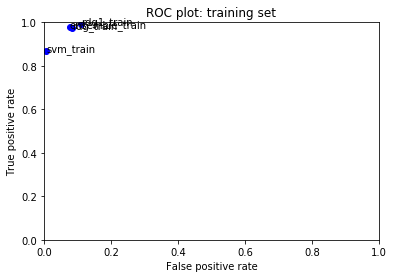

In [10]:
fits = [svm_performance_train, rdg_performance_train, rdg1_performance_train, ensemble_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: training set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

# Test Data

In [11]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3244, 'Neg': 28671, 'TP': 2322, 'TN': 28088, 'FP': 583, 'FN': 922, 'Accuracy': 0.9528434905216983, 'Precision': 0.7993115318416524, 'Recall': 0.7157829839704068, 'desc': 'svm_test'}


In [12]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3244, 'Neg': 28671, 'TP': 2870, 'TN': 25774, 'FP': 2897, 'FN': 374, 'Accuracy': 0.8975090083033057, 'Precision': 0.49765909485000864, 'Recall': 0.8847102342786684, 'desc': 'rdg_test'}


In [13]:
rdg1_performance_test = BinaryClassificationPerformance(rdg1.predict(X_test), y_test, 'rdg1_test')
rdg1_performance_test.compute_measures()
print(rdg1_performance_test.performance_measures)

{'Pos': 3244, 'Neg': 28671, 'TP': 3085, 'TN': 23905, 'FP': 4766, 'FN': 159, 'Accuracy': 0.8456838477205076, 'Precision': 0.3929435740669978, 'Recall': 0.9509864364981504, 'desc': 'rdg1_test'}


In [14]:
ensemble_performance_test = BinaryClassificationPerformance(ensemble.predict(X_test), y_test, 'ensemble_test')
ensemble_performance_test.compute_measures()
print(ensemble_performance_test.performance_measures)

{'Pos': 3244, 'Neg': 28671, 'TP': 2927, 'TN': 25763, 'FP': 2908, 'FN': 317, 'Accuracy': 0.8989503368322106, 'Precision': 0.5016281062553556, 'Recall': 0.9022811344019729, 'desc': 'ensemble_test'}


In [15]:
# read in test data for submission
raw_data, X_test_submission = process_raw_data(fn='toxiccomments_test.csv', my_random_seed=42, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0          72          10
1          13           1
2          16           0
3          38           3
4           7           1
5          16           2
6          31           4
7           6       

In [16]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = svm.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.22518999242641874


In [17]:
### ROC plot for test data

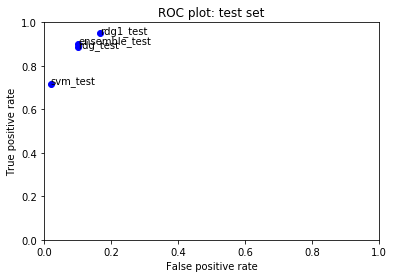

In [18]:
fits = [svm_performance_test, rdg_performance_test, rdg1_performance_test, ensemble_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()